## Trabajo Final: Análisis Comparativo de Métodos de Regresión
#### Dataset: Student Performance: https://archive.ics.uci.edu/ml/datasets/student+performance
**Sofía A. Córdoba**

In [35]:
#----------Importamos librerías-----------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#regresion lineal multiple
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from scipy import stats
#arbol
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
#red neuronal
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
#comparacion
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error




print("Libraries imported successfully!")

Libraries imported successfully!


In [45]:
#-----------Cargamos Data set--------------------
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 

# data (as pandas dataframes) 
student_df = student_performance.data.features
student_target = student_performance.data.targets


#se debe hacer: pip install ucimlrepo, desde la ventana de comandos.

## 1. Análisis Exploratorio de Datos

### 1.1 Descripción del Dataset: Student Performance

Este dataset fue obtenido del repositorio de UCI Machine Learning Repository (ID: 320).

Estos datos abordan el rendimiento de los estudiantes en la educación secundaria de dos escuelas portuguesas. Los atributos de los datos incluyen las calificaciones de los estudiantes, las características demográficas, sociales y relacionadas con la escuela y se recopilaron mediante el uso de informes y cuestionarios escolares. Se proporcionan dos conjuntos de datos sobre el rendimiento en dos asignaturas distintas: Matemáticas (mat) y Lengua Portuguesa (por). En [Cortez y Silva, 2008], los dos conjuntos de datos se modelaron bajo tareas de clasificación y regresión binarias/de cinco niveles. Nota importante: el atributo objetivo G3 tiene una fuerte correlación con los atributos G2 y G1. Esto se debe a que G3 es la nota del último curso (emitida en el 3º periodo), mientras que G1 y G2 corresponden a las notas del 1º y 2º periodo. Es más difícil predecir G3 sin G2 y G1, pero dicha predicción es mucho más útil (consulte la fuente del documento para obtener más detalles).

El análisis de este dataset es relevante porque permite estudiar qué factores impactan en el rendimiento académico, lo cual puede ayudar a diseñar políticas educativas más efectivas, brindar apoyos dirigidos a estudiantes en riesgo, y comprender mejor el entorno educativo.

En este trabajo se abordará un problema de regresión, prediciendo el rendimiento académico de los estudiantes a partir de las variables disponibles.


### 1.2 Análisis descriptivo:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

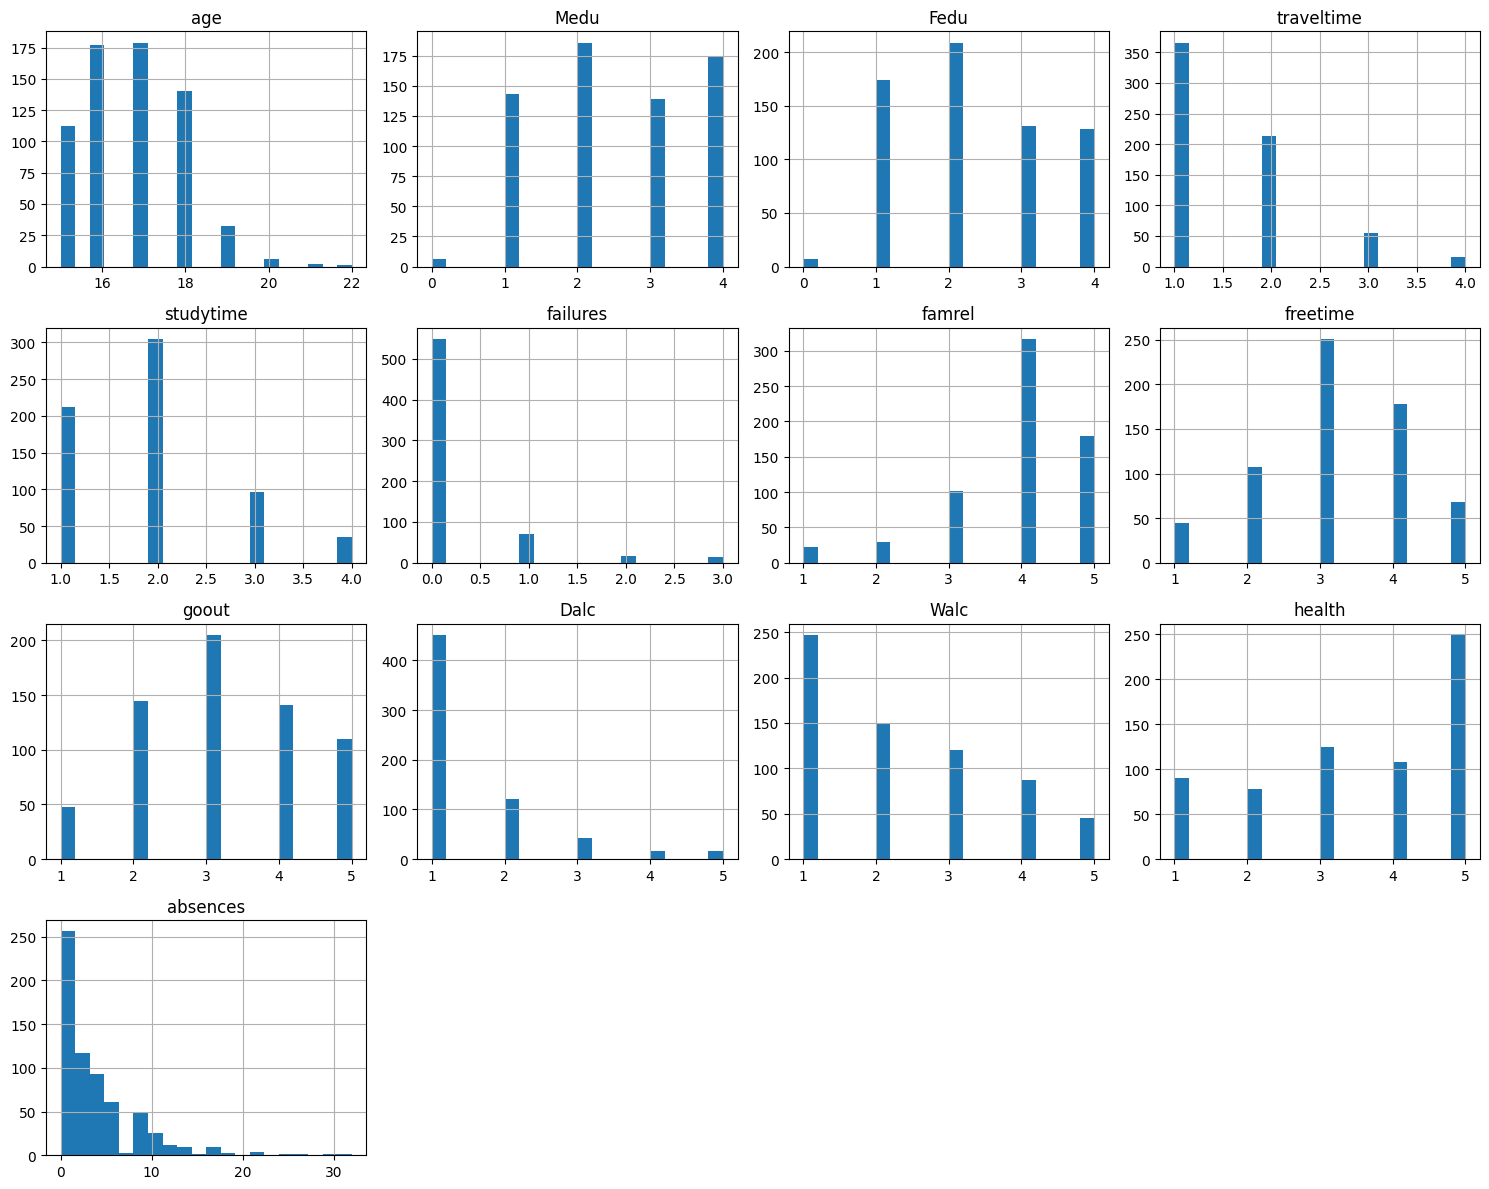

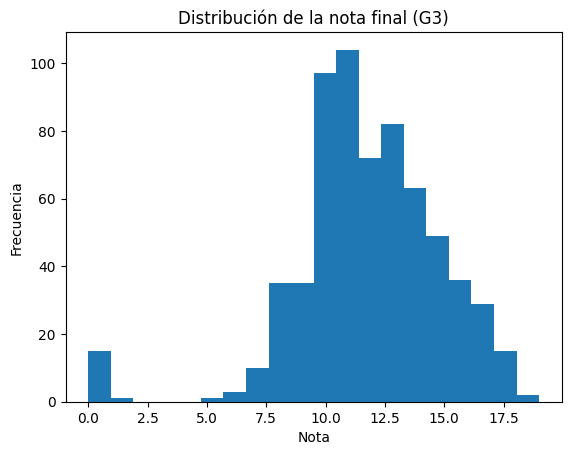

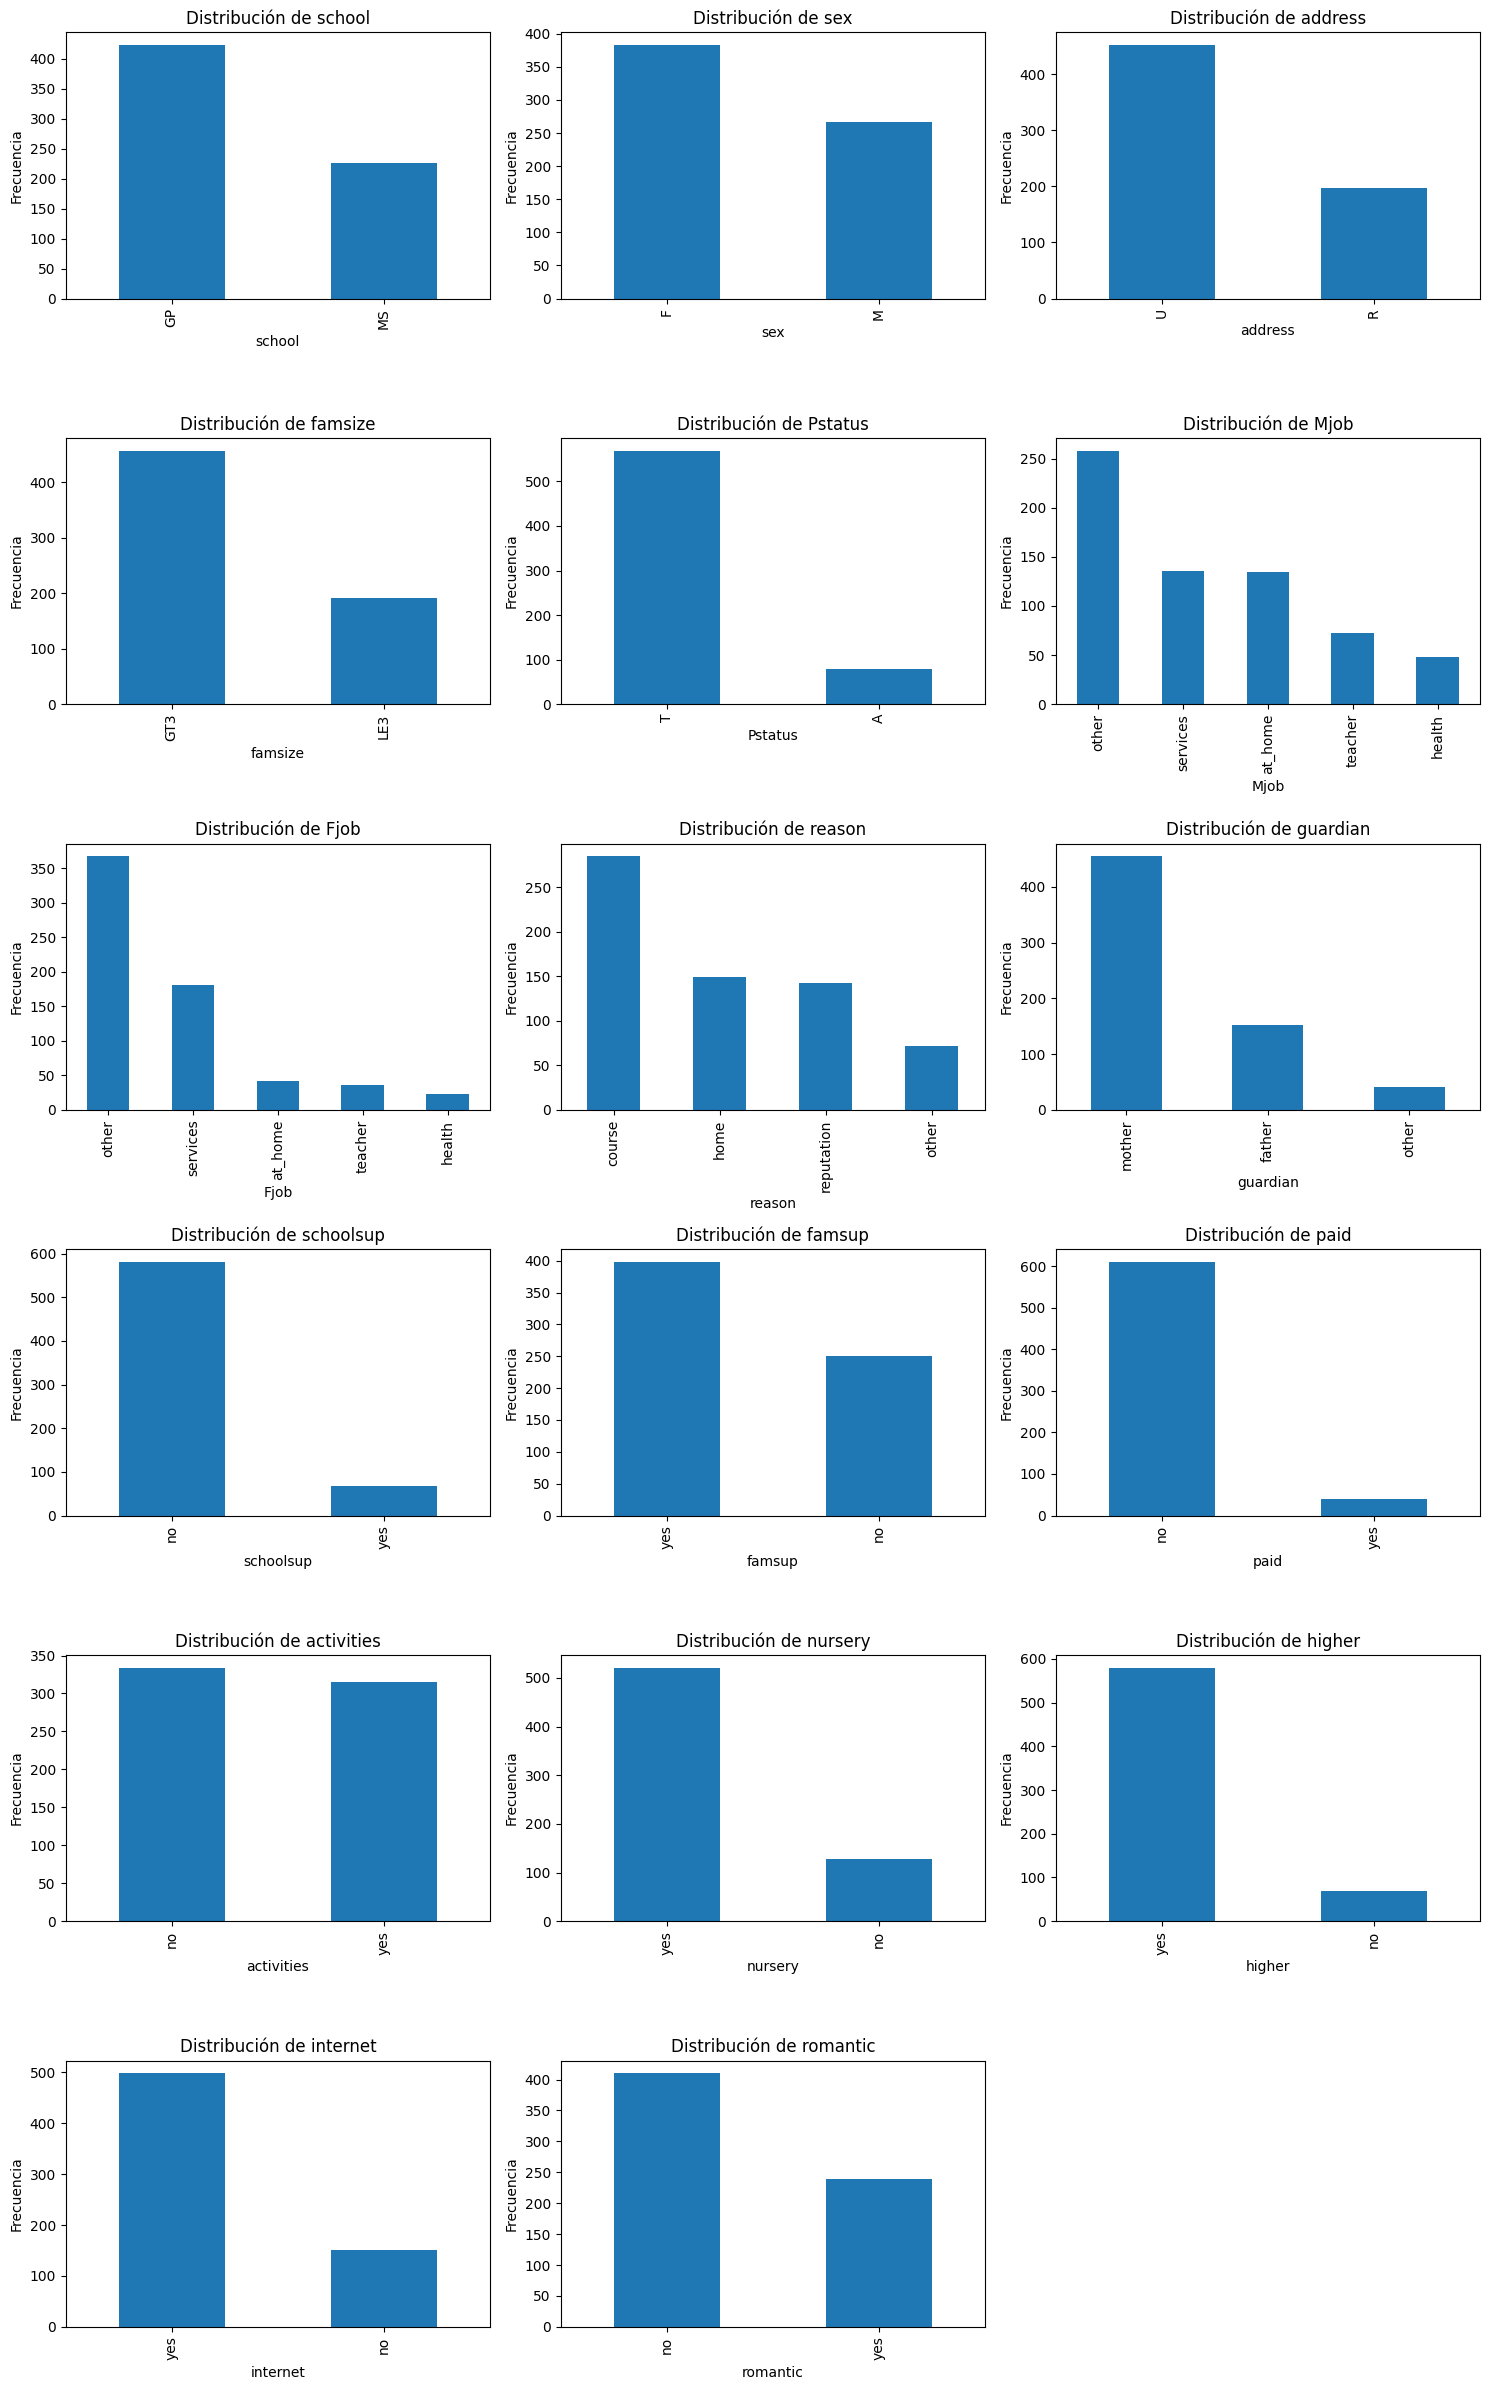

In [3]:
# Estadísticas básicas de las variables
student_df.describe(include='all')

#Valores faltantes:
student_df.info()

#Distribuciones de variables numéricas
student_df.hist(figsize=(15, 12), bins=20)
plt.tight_layout()
plt.show()

# Distribución de la variable objetivo
student_target['G3'].plot(kind='hist', bins=20, title='Distribución de la nota final (G3)')
plt.xlabel('Nota')
plt.ylabel('Frecuencia')
plt.show()

# Distribución Variables categóricas
cat_cols = student_df.select_dtypes(include=['object', 'category']).columns

n = len(cat_cols)
n_cols = 3  # columnas por fila
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    student_df[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ocultar ejes vacíos si los hay
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




### 1.3 Análisis de correlaciones

**1.3.1 Matriz de correlación:** Sirve para ver qué tan relacionadas están las variables numéricas entre sí y con la variable objetivo (G3, por ejemplo). Es útil para:

Identificar variables que están muy correlacionadas entre sí (posible redundancia)

Ver qué variables se relacionan fuertemente con G3 (las más predictivas)

RESULTADO: 
A continuación se presentan las correlaciones entre las variables explicativas numéricas y la nota final (`G3`), ordenadas por su importancia en valor absoluto:

- **Failures (-0.39):** La variable con mayor correlación en valor absoluto. Indica que un mayor número de fracasos previos está asociado a una menor nota final, lo cual es consistente con la intuición y la literatura educativa.

- **Studytime (0.25):** Más tiempo dedicado al estudio se relaciona con mejores resultados académicos, aunque la correlación es moderada.

- **Medu (0.24) y Fedu (0.21):** La educación de la madre y del padre tienen una correlación positiva moderada con el rendimiento, lo que sugiere la influencia del entorno familiar.

- **Dalc (-0.20) y Walc (-0.17):** El consumo de alcohol durante la semana y fines de semana está negativamente correlacionado con la nota final, indicando un posible impacto negativo en el desempeño.

- **Otras variables (traveltime, freetime, age, health, absences, goout, famrel):** Presentan correlaciones bajas, lo que sugiere un impacto lineal directo menor en la nota final.

Estas observaciones ayudarán a guiar la selección de variables para los modelos de regresión, priorizando aquellas con mayor relación lineal con la variable objetivo.


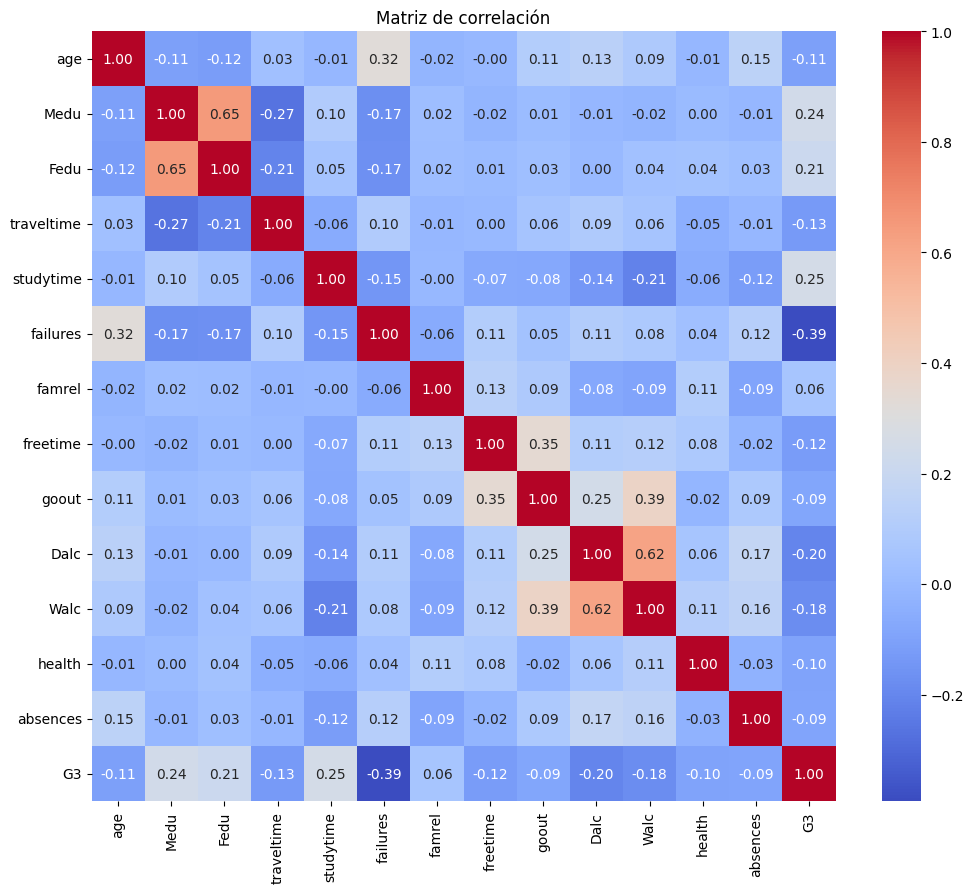

failures     -0.393316
studytime     0.249789
Medu          0.240151
Fedu          0.211800
Dalc         -0.204719
Walc         -0.176619
traveltime   -0.127173
freetime     -0.122705
age          -0.106505
health       -0.098851
absences     -0.091379
goout        -0.087641
famrel        0.063361
Name: G3, dtype: float64


In [4]:
# -------------Matriz de correlacion-------------

df_full = student_df.copy()
df_full['G3'] = student_target['G3']


# Correlaciones entre variables numéricas
corr_matrix = df_full.corr(numeric_only=True)

# Mostrar como mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

# Asegurate de tener el DataFrame completo con G3
df_full = student_df.copy()
df_full['G3'] = student_target['G3']


# Extraemos la columna de correlaciones con G3, excepto la correlación de G3 consigo misma
corr_with_target = corr_matrix['G3'].drop('G3')

# Ordenamos por valor absoluto descendente
corr_with_target_sorted = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

print(corr_with_target_sorted)



**1.3.2 Multicolinealidad:** Esto ocurre cuando dos o más variables explicativas están fuertemente correlacionadas entre sí. Puede hacer que los coeficientes de una regresión múltiple sean inestables o difíciles de interpretar.

Se analiza con el VIF (Variance Inflation Factor).

OBSERVACION LUEGO DE CORRER LA CELDA: Todos los valores de VIF para las variables están por debajo de 5, eso indica poca o ninguna multicolinealidad preocupante.

Las variables parecen independientes entre sí, lo que es bueno para la regresión múltiple.

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Crear dataframe con variables numéricas
X_num = df_full.select_dtypes(include=['number']).drop(columns=['G3'])

# Agregar constante (intercepto)
X_num_const = add_constant(X_num)

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X_num_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_num_const.values, i) for i in range(X_num_const.shape[1])]

print(vif_data)

      Variable         VIF
0        const  266.629731
1          age    1.168318
2         Medu    1.806310
3         Fedu    1.761638
4   traveltime    1.098958
5    studytime    1.089108
6     failures    1.198411
7       famrel    1.067159
8     freetime    1.187311
9        goout    1.370399
10        Dalc    1.663791
11        Walc    1.898820
12      health    1.052294
13    absences    1.081418


### 1.4 Visualizaciones

**1.4.1 Scatter Plots**
Análisis gráfico de relaciones con la variable objetivo G3
Para explorar las relaciones entre las variables numéricas seleccionadas y la variable objetivo G3 (nota final del alumno), se graficaron diagramas de dispersión. Estos permiten visualizar la forma de la relación y detectar patrones, tendencias, valores atípicos o no linealidades.

Principales observaciones:
failures vs. G3: Se observa una clara relación negativa. A mayor cantidad de materias desaprobadas (failures), menor suele ser la nota final (G3). Además, como failures es una variable discreta, los puntos se agrupan en columnas verticales.

studytime, Medu, Fedu vs. G3: Estas variables muestran una relación positiva débil, pero visible. A mayor tiempo de estudio y mayor nivel educativo de los padres, tiende a aumentar G3.

Dalc, Walc vs. G3: El consumo de alcohol diario y de fin de semana muestra una relación negativa con el rendimiento académico, aunque con más dispersión. A mayor consumo, la nota final tiende a ser más baja.

Otras variables (age, health, absences, goout, freetime): No se observan relaciones lineales claras con G3, aunque en algunos casos como goout o absences se perciben leves patrones decrecientes.

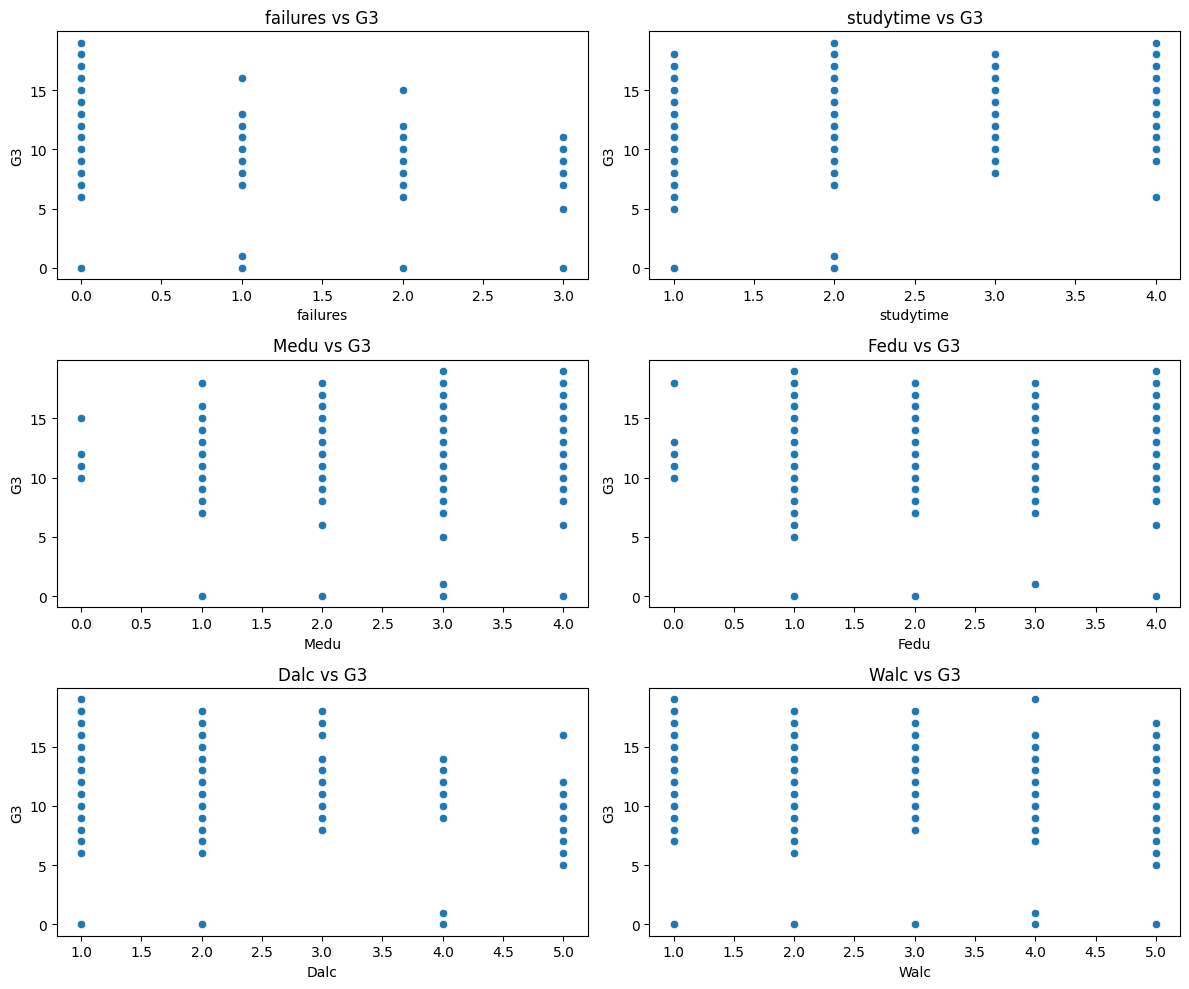

In [6]:
# Lista de variables numéricas más correlacionadas con G3
top_vars = ['failures', 'studytime', 'Medu', 'Fedu', 'Dalc', 'Walc']

# Creamos los scatter plots
n_cols = 2
n_rows = (len(top_vars) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
axes = axes.flatten()

for i, var in enumerate(top_vars):
    sns.scatterplot(x=df_full[var], y=df_full['G3'], ax=axes[i])
    axes[i].set_title(f'{var} vs G3')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('G3')

# Ocultar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


**1.4.2 Box Plots**

Es una herramienta fundamental en el análisis exploratorio es el diagrama de caja (boxplot), que permite visualizar cómo se distribuye la variable objetivo (G3, la nota final) en función de distintas variables categóricas del dataset.

Los boxplots muestran de manera clara la mediana del rendimiento (G3) para cada categoría, la dispersión (rango intercuartílico) y la presencia de valores atípicos; y las comparaciones directas entre categorías (por ejemplo, rendimiento por sexo, tipo de escuela, acceso a internet, etc.).

Este tipo de gráfico es útil para detectar patrones o diferencias significativas entre grupos, lo cual puede aportar información valiosa al momento de seleccionar variables relevantes para los modelos predictivos o de interpretar los resultados.

Se seleccionaron variables categóricas que, por su naturaleza y contexto educativo, pueden influir en el rendimiento académico medido por la nota final (G3):

    school: La escuela a la que asiste el estudiante puede reflejar diferencias en recursos, ambiente o metodologías pedagógicas.
    address: El entorno geográfico (urbano o rural) puede afectar el acceso a recursos y oportunidades educativas.
    Pstatus: El estado de convivencia de los padres refleja el entorno familiar y estabilidad, factores relevantes para el desempeño académico.
    higher: La intención de continuar con estudios superiores puede indicar motivación y metas académicas.
    romantic: Tener una relación amorosa puede influir en la dedicación o distracción hacia los estudios.
    famsup: El apoyo educativo familiar es un factor directo que puede facilitar el aprendizaje.
    activities: La participación en actividades extracurriculares puede tener efectos tanto positivos (desarrollo social) como negativos (dispersión del tiempo).

Estos boxplots permiten visualizar la distribución y posibles diferencias en la nota final según estas características, ayudando a identificar variables relevantes para el modelado y a entender mejor el contexto educativo de los estudiantes.



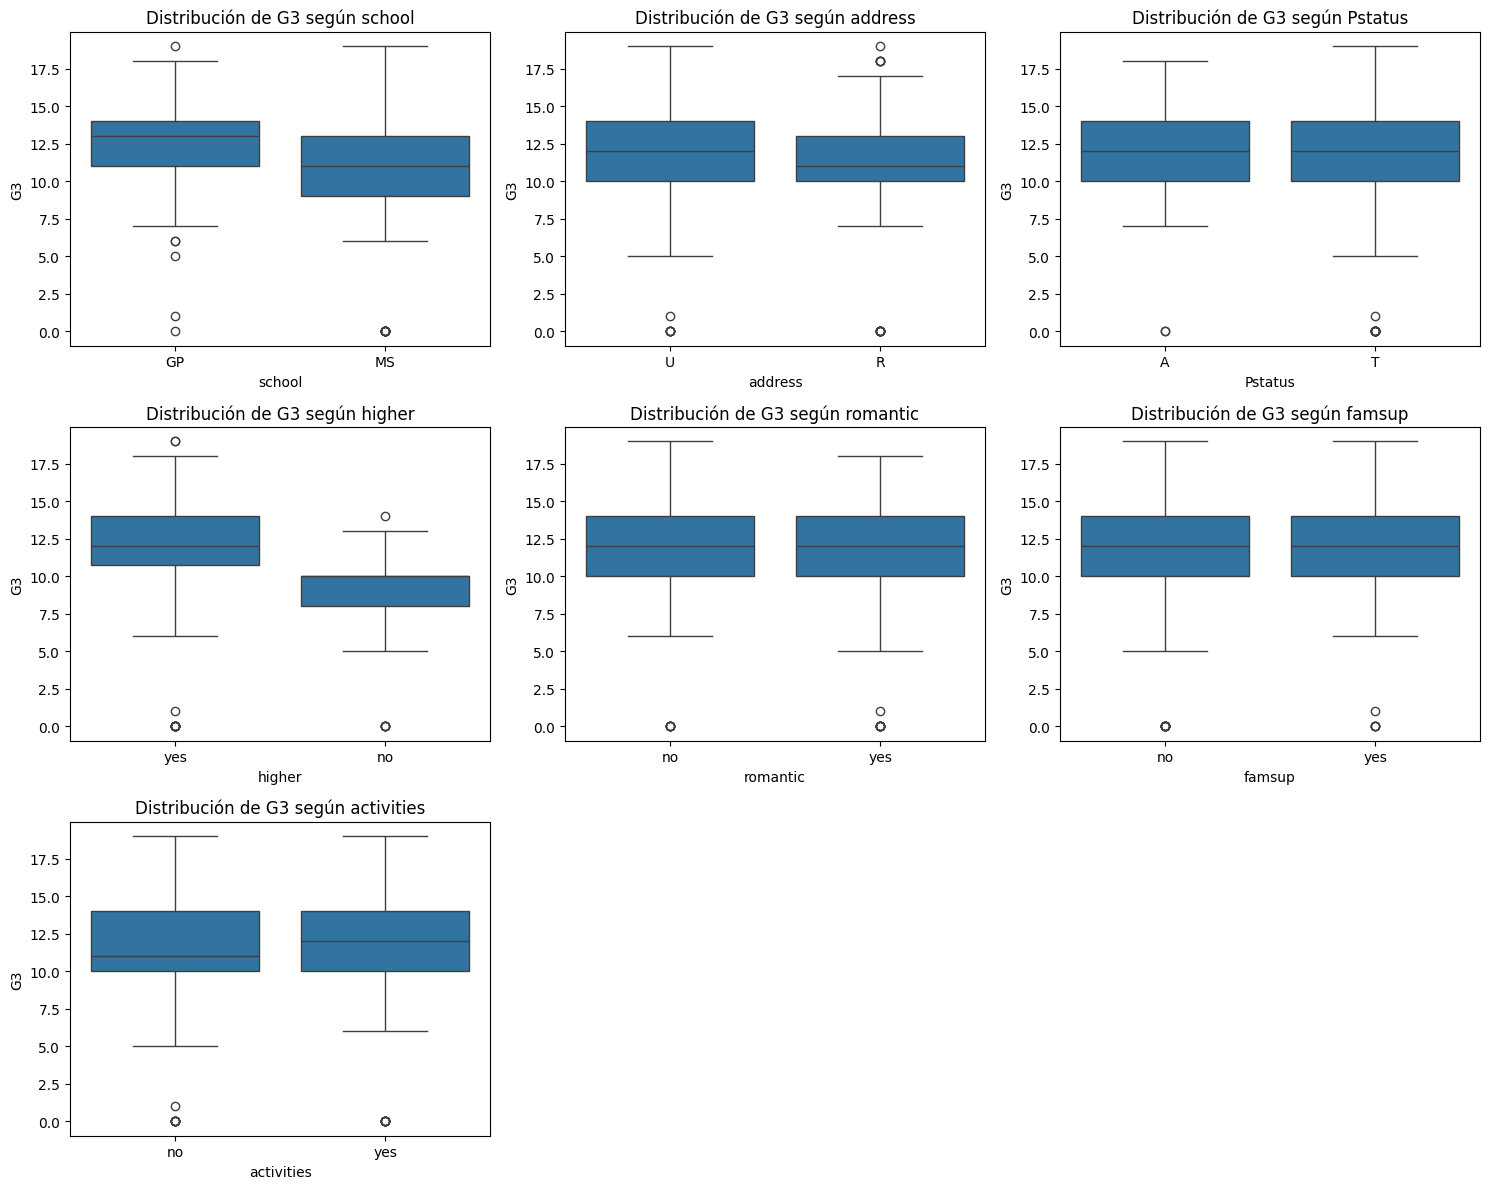

In [7]:
df_full = student_df.copy()
df_full['G3'] = student_target['G3']

# Nuevas variables categóricas de interés
categorical_vars = ['school', 'address', 'Pstatus', 'higher', 'romantic', 
                    'famsup', 'activities']

# Ajustamos tamaño del gráfico
n = len(categorical_vars)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, var in enumerate(categorical_vars):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=var, y='G3', data=df_full)
    plt.title(f'Distribución de G3 según {var}')
    plt.xlabel(var)
    plt.ylabel('G3')

plt.tight_layout()
plt.show()


### 1.5 Preprocesamiento 

Para el análisis de outliers se seleccionaron variables numéricas que tienen sentido desde el punto de vista del estudio y que pueden impactar en el rendimiento académico o en la calidad del modelo predictivo.

Las variables elegidas incluyen tanto variables continuas como discretas con varios niveles, que representan características relevantes del estudiante y su entorno:

    age: La edad del estudiante puede variar y valores extremos pueden reflejar casos atípicos.
    Medu y Fedu: Nivel educativo de la madre y del padre, aunque son variables ordinales con pocos niveles, es importante verificar si existen valores fuera del rango esperado.
    traveltime y studytime: Tiempo de traslado a la escuela y tiempo dedicado al estudio, que pueden variar y presentar valores atípicos.
    failures: Número de materias reprobadas anteriormente, variable discreta pero clave en el rendimiento.
    famrel, freetime, goout: Variables que miden la calidad de relaciones familiares, tiempo libre y salidas con amigos, relevantes para el contexto social del estudiante.
    Dalc y Walc: Consumo de alcohol durante la semana y fines de semana, que pueden afectar el desempeño académico.
    health: Autoevaluación de la salud, con valores que pueden ser atípicos.
    absences: Número de ausencias escolares, variable con posible sesgo y valores extremos.


In [8]:
#----------------Valores faltantes-----------
missing_values = df_full.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values[missing_values > 0])
#NO HAY, YA LO DECIA EL REPOSITORIO.

#---------------Outliers------------------
def detect_outliers_iqr(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[variable] < Q1 - 1.5 * IQR) | (data[variable] > Q3 + 1.5 * IQR)]
    return outliers

# Seleccionamos variables numéricas para analizar
num_vars = df_full.select_dtypes(include=['number']).columns.tolist()
num_vars.remove('G3')  # Si querés podés dejarla o no analizar la variable objetivo

# Detectar outliers y contar cuántos hay por variable
outliers_summary = {}

for var in num_vars:
    outliers_var = detect_outliers_iqr(df_full, var)
    outliers_summary[var] = len(outliers_var)

# Mostrar resumen
for var, count in outliers_summary.items():
    print(f"{var}: {count} outliers detectados")





Valores faltantes por columna:
Series([], dtype: int64)
age: 1 outliers detectados
Medu: 0 outliers detectados
Fedu: 0 outliers detectados
traveltime: 16 outliers detectados
studytime: 35 outliers detectados
failures: 100 outliers detectados
famrel: 51 outliers detectados
freetime: 45 outliers detectados
goout: 0 outliers detectados
Dalc: 34 outliers detectados
Walc: 0 outliers detectados
health: 0 outliers detectados
absences: 21 outliers detectados


**1.5.1 Transformaciones**

Para decidir si aplicar transformaciones a las variables numéricas, se consideró el tipo de modelo que se implementará, así como las características estadísticas de las variables.

En particular, se analizaron variables candidatas (failures, studytime, traveltime, Dalc, absences) debido a que presentaban asimetrías y curtosis elevadas, lo que puede afectar la calidad del modelado, especialmente en modelos lineales.

Regresión lineal múltiple:
Este modelo asume que las variables explicativas y los residuos tienen distribuciones aproximadamente normales y relaciones lineales con la variable objetivo. Las variables con alta asimetría y curtosis pueden violar estos supuestos, afectando la estabilidad e interpretabilidad del modelo. Por ello, para la regresión lineal se decidió aplicar transformaciones (como la transformación Yeo-Johnson) en las variables mencionadas, para mejorar la normalidad, linealidad y reducir el impacto de valores atípicos.

Árboles de regresión y redes neuronales (MLP):
Estos modelos son menos sensibles a la distribución y escala de las variables, ya que capturan relaciones no lineales y son robustos frente a valores extremos. Por lo tanto, para estos modelos se optó por no aplicar transformaciones a las variables, manteniendo su escala original para preservar la interpretabilidad y simplicidad, aunque se podrá evaluar la influencia de transformaciones en etapas posteriores.

Esta estrategia permite un análisis equilibrado, aplicando transformaciones donde teóricamente aportan beneficios claros (regresión lineal) y evitando modificaciones innecesarias donde no son estrictamente requeridas (modelos no lineales).


Variable: failures
Skewness original: 3.086, transformado: 1.916
Kurtosis original: 9.740, transformado: 1.672
Shapiro-Wilk p-value original: 0.0000
Shapiro-Wilk p-value transformado: 0.0000


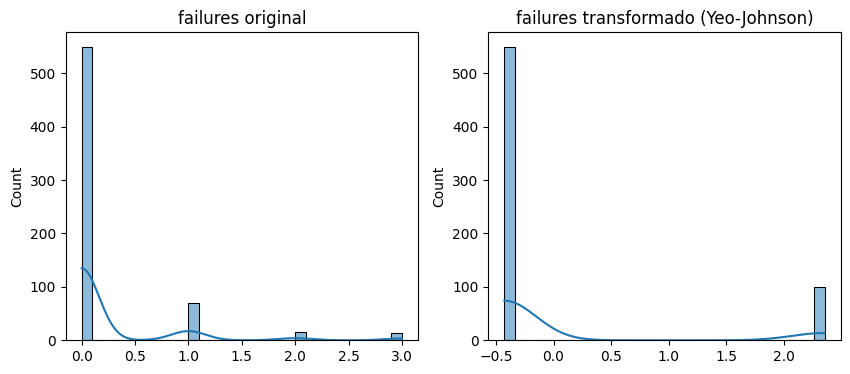


Variable: studytime
Skewness original: 0.698, transformado: 0.027
Kurtosis original: 0.028, transformado: -0.995
Shapiro-Wilk p-value original: 0.0000
Shapiro-Wilk p-value transformado: 0.0000


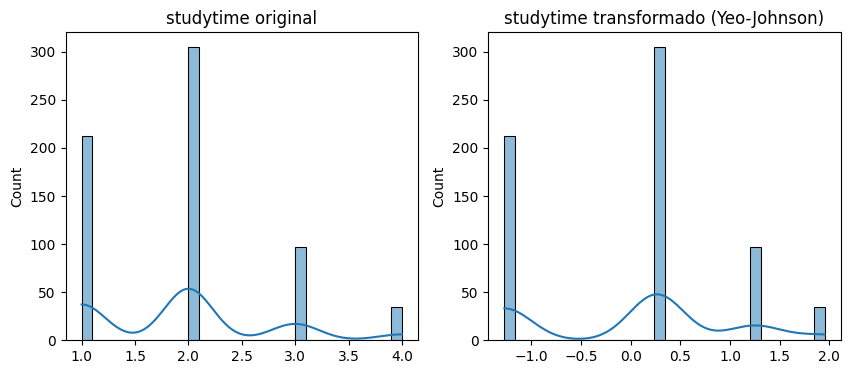


Variable: traveltime
Skewness original: 1.245, transformado: 0.367
Kurtosis original: 1.091, transformado: -1.696
Shapiro-Wilk p-value original: 0.0000
Shapiro-Wilk p-value transformado: 0.0000


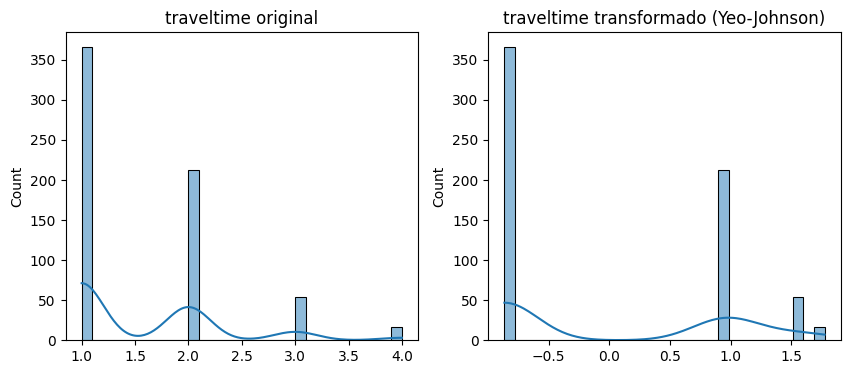


Variable: Dalc
Skewness original: 2.137, transformado: 0.875
Kurtosis original: 4.307, transformado: -1.191
Shapiro-Wilk p-value original: 0.0000
Shapiro-Wilk p-value transformado: 0.0000


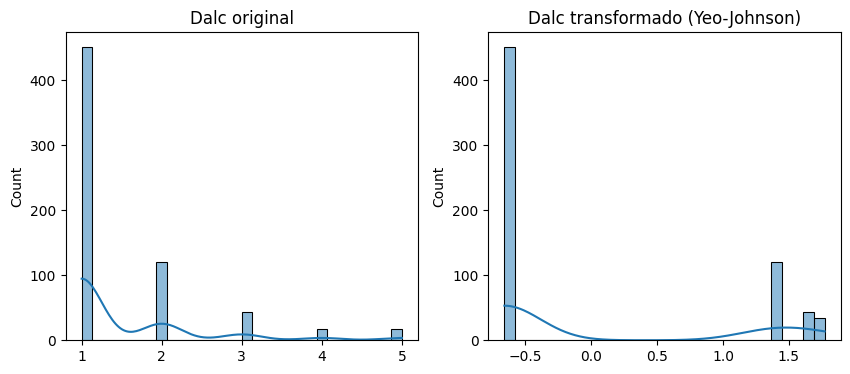


Variable: absences
Skewness original: 2.016, transformado: 0.057
Kurtosis original: 5.727, transformado: -1.406
Shapiro-Wilk p-value original: 0.0000
Shapiro-Wilk p-value transformado: 0.0000


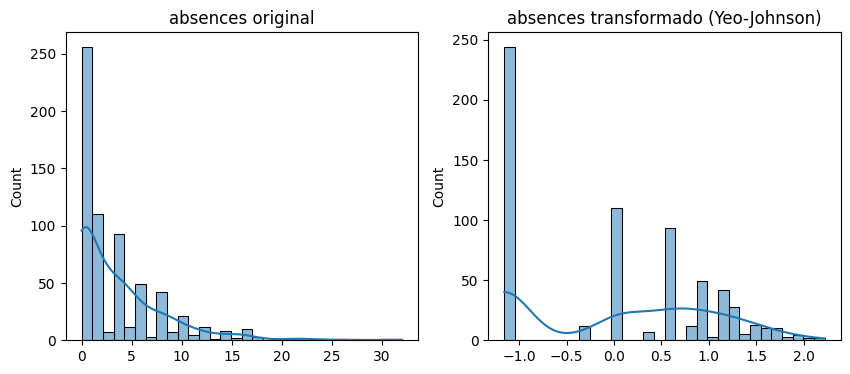

In [9]:
from scipy.stats import skew, kurtosis, shapiro
from sklearn.preprocessing import PowerTransformer

vars_to_test = ['failures', 'studytime', 'traveltime', 'Dalc', 'absences']

df = df_full.copy()

for var in vars_to_test:
    print(f"\nVariable: {var}")
    data_orig = df[var].values.reshape(-1, 1)
    
    # Transformación Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    data_trans = pt.fit_transform(data_orig)
    
    # Estadísticos
    skew_orig = skew(data_orig.flatten())
    kurt_orig = kurtosis(data_orig.flatten())
    skew_trans = skew(data_trans.flatten())
    kurt_trans = kurtosis(data_trans.flatten())
    
    # Test Shapiro-Wilk
    p_orig = shapiro(data_orig.flatten())[1]
    p_trans = shapiro(data_trans.flatten())[1]
    
    print(f"Skewness original: {skew_orig:.3f}, transformado: {skew_trans:.3f}")
    print(f"Kurtosis original: {kurt_orig:.3f}, transformado: {kurt_trans:.3f}")
    print(f"Shapiro-Wilk p-value original: {p_orig:.4f}")
    print(f"Shapiro-Wilk p-value transformado: {p_trans:.4f}")
    
    # Histogramas para comparar
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(data_orig.flatten(), bins=30, kde=True)
    plt.title(f'{var} original')
    plt.subplot(1,2,2)
    sns.histplot(data_trans.flatten(), bins=30, kde=True)
    plt.title(f'{var} transformado (Yeo-Johnson)')
    plt.show()


#  2. Implementación de Modelos

## 2.1 Regresión Lineal Múltiple

**Preparación de Datos para Modelado**

- Separamos características (`X`) y variable objetivo (`G3`).
- Convertimos variables categóricas a variables dummy con `pd.get_dummies()`.
- Dividimos los datos en entrenamiento (80%) y prueba (20%) con `train_test_split`.
- Estandarizamos las variables con `StandardScaler` (importante para redes neuronales).
- Imprimimos tamaños de los conjuntos y rango de la variable objetivo.

Resultados:
- Tamaño entrenamiento: (519, 39)
- Tamaño prueba: (130, 39)
- Rango de y_train: [0.00, 19.00]


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Paso 1: convertir categóricas a dummies
X = df_full.drop('G3', axis=1)
X = pd.get_dummies(X, drop_first=True)  # evita multicolinealidad

y = df_full['G3']

# Paso 2: división en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Paso 3: escalar características numéricas (todas son numéricas ya)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== PREPARACIÓN DE DATOS ===")
print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")
print(f"Rango de y_train: [{y_train.min():.2f}, {y_train.max():.2f}]")


=== PREPARACIÓN DE DATOS ===
Tamaño entrenamiento: (519, 39)
Tamaño prueba: (130, 39)
Rango de y_train: [0.00, 19.00]


**Implementación de Regresión Lineal Múltiple**

- Entrenamos un modelo de regresión lineal con los datos de entrenamiento.
- Calculamos predicciones y métricas de desempeño (MSE y R²) para entrenamiento y prueba.
- Mostramos los coeficientes estimados y el intercepto del modelo.

Resultados obtenidos:

    MSE Entrenamiento: 6.4476
    MSE Prueba: 8.1898
    R² Entrenamiento: 0.3874
    R² Prueba: 0.1602

In [21]:
## Celda 4: Implementación de Regresión Lineal Múltiple
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("=== REGRESIÓN LINEAL MÚLTIPLE ===")

# Entrenar modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predicciones
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Métricas
lr_train_mse = mean_squared_error(y_train, y_pred_lr_train)
lr_test_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)

print(f"MSE Entrenamiento: {lr_train_mse:.4f}")
print(f"MSE Prueba: {lr_test_mse:.4f}")
print(f"R² Entrenamiento: {lr_train_r2:.4f}")
print(f"R² Prueba: {lr_test_r2:.4f}")

# Coeficientes
print(f"\nCoeficientes del modelo:")
for i, coef in enumerate(lr_model.coef_):
    print(f"  X{i+1}: {coef:.4f}")
print(f"  Intercepto: {lr_model.intercept_:.4f}")


=== REGRESIÓN LINEAL MÚLTIPLE ===
MSE Entrenamiento: 6.4476
MSE Prueba: 8.1898
R² Entrenamiento: 0.3874
R² Prueba: 0.1602

Coeficientes del modelo:
  X1: 0.1084
  X2: -0.0236
  X3: 0.2614
  X4: -0.0288
  X5: 0.3690
  X6: -1.4987
  X7: 0.1687
  X8: -0.1222
  X9: -0.1460
  X10: -0.2494
  X11: -0.0048
  X12: -0.2280
  X13: -0.0509
  X14: -1.3937
  X15: -0.4774
  X16: 0.2855
  X17: 0.1721
  X18: -0.1469
  X19: 1.0449
  X20: 0.1521
  X21: 0.4687
  X22: 0.5502
  X23: -1.0411
  X24: -0.4843
  X25: -1.0993
  X26: -0.5847
  X27: -0.1696
  X28: -0.7148
  X29: 0.2876
  X30: -0.3017
  X31: 0.5333
  X32: -1.6034
  X33: -0.0075
  X34: -0.3478
  X35: 0.1768
  X36: -0.1074
  X37: 1.6869
  X38: 0.3029
  X39: -0.3720
  Intercepto: 10.4813


**Análisis de Regresión Lineal**

En esta celda visualizamos los resultados del modelo de regresión lineal:

- **Gráfico 1:** Valores reales vs predichos en el conjunto de prueba.  
  La línea roja discontinua representa el ajuste ideal (predicción = valor real).

- **Gráfico 2:** Análisis de residuos, mostrando la diferencia entre valores reales y predichos respecto a las predicciones.  
  La línea horizontal en cero ayuda a identificar sesgos o patrones.

- **Gráfico 3:** Importancia de características basada en el valor absoluto de los coeficientes del modelo.  
  Aquí mostramos los nombres reales de las variables para facilitar la interpretación.

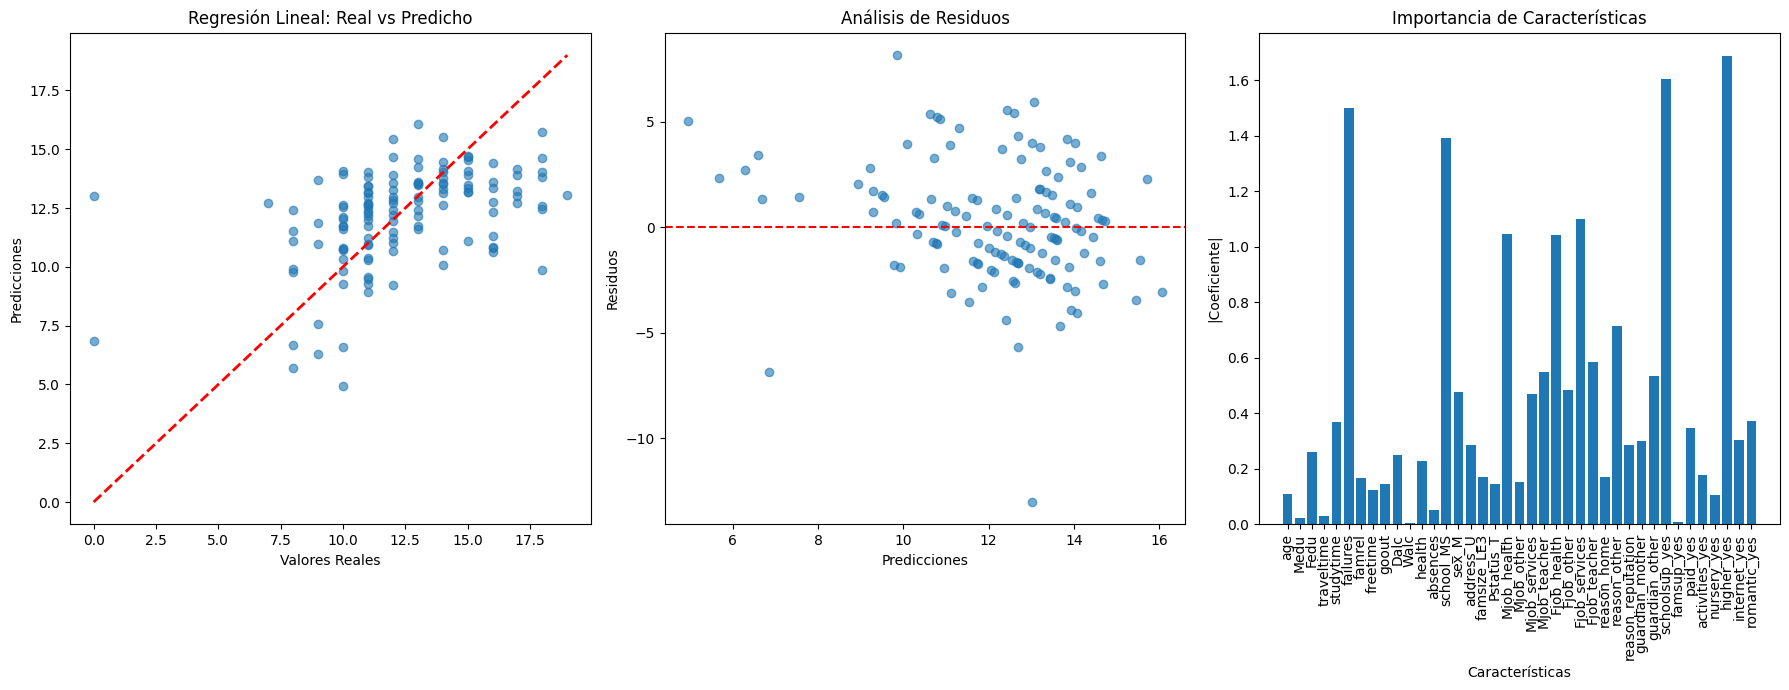

In [25]:
## Celda 5: Análisis de Regresión Lineal
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 7))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal: Real vs Predicho')

# Gráfico 2: Residuos
plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_lr_test
plt.scatter(y_pred_lr_test, residuals_lr, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')

# Gráfico 3: Importancia de características (coeficientes absolutos)
features = X_train.columns  # nombres reales después del get_dummies
feature_importance = np.abs(lr_model.coef_)

plt.subplot(1, 3, 3)
plt.bar(features, feature_importance)
plt.xlabel('Características')
plt.ylabel('|Coeficiente|')
plt.title('Importancia de Características')
plt.xticks(rotation=90)  # rotar para que se lean mejor

plt.tight_layout()
plt.show()


## 2.2 Árbol de Regresión 

**Árbol de Regresión**

Se implementó un modelo de Árbol de Decisión para regresión, buscando optimizar la profundidad del árbol (`max_depth`) mediante validación cruzada con 5 particiones. Se evaluaron distintas profundidades (3, 5, 7, 10, 15, 20) y se seleccionó la que obtuvo el mejor desempeño promedio en R².

El mejor valor encontrado fue una profundidad de **3**, con la cual se entrenó el modelo final y se evaluó su desempeño tanto en el conjunto de entrenamiento como en el de prueba.

### Métricas obtenidas:
- **Mejor profundidad:** 3  
- **MSE Entrenamiento:** 6.8817  
- **MSE Prueba:** 8.9309  
- **R² Entrenamiento:** 0.3462  
- **R² Prueba:** 0.0842  

El modelo presenta una mejora respecto a la regresión lineal múltiple, especialmente en los datos de entrenamiento. Sin embargo, el bajo R² en prueba indica que el árbol no logra generalizar bien, posiblemente por la complejidad del problema o la falta de variables altamente predictivas.


In [26]:
## Celda 6: Implementación de Árbol de Regresión
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

print("=== ÁRBOL DE REGRESIÓN ===")

# Buscar la mejor profundidad con validación cruzada
depths = [3, 5, 7, 10, 15, 20]
best_depth = 0
best_score = float('-inf')

for depth in depths:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_temp, X_train, y_train, cv=5, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_depth = depth

print(f"Mejor profundidad encontrada: {best_depth}")

# Entrenar modelo final con la mejor profundidad
tree_model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
tree_model.fit(X_train, y_train)

# Predicciones
y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

# Métricas
tree_train_mse = mean_squared_error(y_train, y_pred_tree_train)
tree_test_mse = mean_squared_error(y_test, y_pred_tree_test)
tree_train_r2 = r2_score(y_train, y_pred_tree_train)
tree_test_r2 = r2_score(y_test, y_pred_tree_test)

print(f"MSE Entrenamiento: {tree_train_mse:.4f}")
print(f"MSE Prueba: {tree_test_mse:.4f}")
print(f"R² Entrenamiento: {tree_train_r2:.4f}")
print(f"R² Prueba: {tree_test_r2:.4f}")


=== ÁRBOL DE REGRESIÓN ===
Mejor profundidad encontrada: 3
MSE Entrenamiento: 6.8817
MSE Prueba: 8.9309
R² Entrenamiento: 0.3462
R² Prueba: 0.0842


**Análisis del Árbol de Regresión**
Se realizaron tres visualizaciones clave para analizar el desempeño del modelo de árbol de regresión:

1. **Valores Reales vs Predichos**  
   El gráfico compara las predicciones del modelo con los valores reales del conjunto de prueba. Aunque se observa cierta correlación, la dispersión indica que el modelo no logra capturar completamente la estructura de los datos, lo cual concuerda con el bajo \( R^2 \) obtenido.

2. **Importancia de Características**  
   Se muestra qué variables fueron más relevantes en las decisiones del árbol. Esto permite interpretar qué atributos tienen mayor peso en la predicción de la variable objetivo. Las variables con mayor importancia podrían ser consideradas en futuros modelos o análisis.

3. **Curva de Validación según Profundidad**  
   Se evaluó el rendimiento del modelo al variar la profundidad máxima del árbol. Se observa que al aumentar la profundidad, el modelo mejora su desempeño en entrenamiento pero no necesariamente en prueba, lo que indica riesgo de sobreajuste. La profundidad óptima elegida fue 3, como compromiso entre sesgo y varianza.


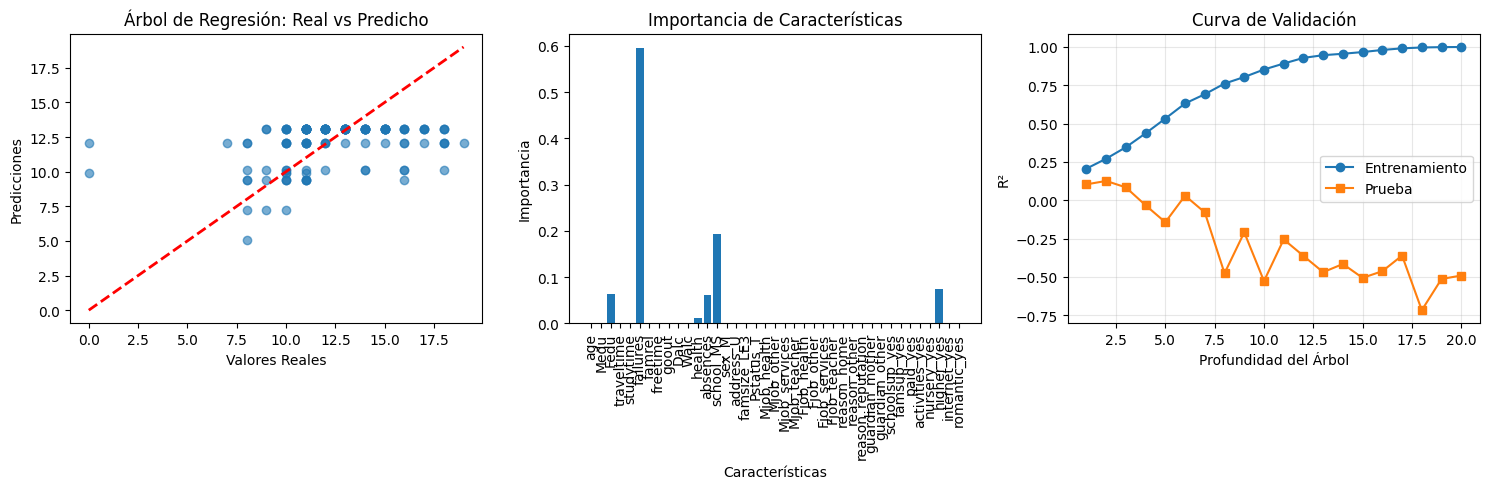

In [28]:
## Celda 7: Análisis de Árbol de Regresión

plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs predichos
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_tree_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Árbol de Regresión: Real vs Predicho')

# Gráfico 2: Importancia de características
plt.subplot(1, 3, 2)
feature_importance = tree_model.feature_importances_
features = X.columns  # usa los nombres reales de tus variables
plt.bar(features, feature_importance)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de Características')
plt.xticks(rotation=90)

# Gráfico 3: Análisis de profundidad
plt.subplot(1, 3, 3)
depths_analysis = range(1, 21)
train_scores = []
test_scores = []

for depth in depths_analysis:
    tree_temp = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_temp.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, tree_temp.predict(X_train)))
    test_scores.append(r2_score(y_test, tree_temp.predict(X_test)))

plt.plot(depths_analysis, train_scores, label='Entrenamiento', marker='o')
plt.plot(depths_analysis, test_scores, label='Prueba', marker='s')
plt.xlabel('Profundidad del Árbol')
plt.ylabel('R²')
plt.title('Curva de Validación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2.3 Redes Neuronales

**Implementacion de la Red**

Se implementó un modelo de red neuronal del tipo *Multilayer Perceptron (MLP)* para el problema de regresión. Se evaluaron distintas arquitecturas de capas ocultas utilizando validación cruzada para determinar cuál ofrecía el mejor desempeño.

**Pasos realizados:**

- Se probaron 5 arquitecturas posibles: `(50,)`, `(100,)`, `(50, 25)`, `(100, 50)`, `(100, 50, 25)`.
- Para cada arquitectura, se usó validación cruzada con `cv=3` y se calculó el promedio del R² obtenido.
- Se seleccionó la arquitectura con mejor desempeño promedio para entrenar el modelo final.
- El modelo fue entrenado con `early_stopping=True` (parada anticipada si no mejora en validación) y `validation_fraction=0.1`.

**Mejor arquitectura encontrada:**  
`(100, 50, 25)`

**Resultados del modelo final:**

- **MSE Entrenamiento:** 4.9200  
- **MSE Prueba:** 9.0642  
- **R² Entrenamiento:** 0.5326  
- **R² Prueba:** 0.0705  
- **Número de iteraciones:** 63

**Interpretación:**

El modelo logra ajustar parcialmente los datos de entrenamiento (R² ≈ 0.53), pero tiene un rendimiento pobre en el conjunto de prueba (R² ≈ 0.07), lo que sugiere que no generaliza bien. Esto puede deberse a que el conjunto de datos contiene relaciones no lineales complejas o ruido, o a la necesidad de mayor ajuste de hiperparámetros (como regularización, tasa de aprendizaje o número de neuronas).



In [29]:
## Celda: Implementación de Red Neuronal
print("=== RED NEURONAL (MLP) ===")

# Definir arquitecturas a evaluar
architectures = [
    (50,), (100,), (50, 25), (100, 50), (100, 50, 25)
]

best_architecture = None
best_score = float('-inf')

# Búsqueda de la mejor arquitectura usando validación cruzada
for arch in architectures:
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=arch,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    scores = cross_val_score(mlp_temp, X_train_scaled, y_train, cv=3, scoring='r2')
    avg_score = scores.mean()
    if avg_score > best_score:
        best_score = avg_score
        best_architecture = arch

print(f"Mejor arquitectura encontrada: {best_architecture}")

# Entrenamiento del modelo final
mlp_model = MLPRegressor(
    hidden_layer_sizes=best_architecture,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_mlp_train = mlp_model.predict(X_train_scaled)
y_pred_mlp_test = mlp_model.predict(X_test_scaled)

# Evaluación
mlp_train_mse = mean_squared_error(y_train, y_pred_mlp_train)
mlp_test_mse = mean_squared_error(y_test, y_pred_mlp_test)
mlp_train_r2 = r2_score(y_train, y_pred_mlp_train)
mlp_test_r2 = r2_score(y_test, y_pred_mlp_test)

# Resultados
print(f"MSE Entrenamiento: {mlp_train_mse:.4f}")
print(f"MSE Prueba: {mlp_test_mse:.4f}")
print(f"R² Entrenamiento: {mlp_train_r2:.4f}")
print(f"R² Prueba: {mlp_test_r2:.4f}")
print(f"Número de iteraciones: {mlp_model.n_iter_}")


=== RED NEURONAL (MLP) ===
Mejor arquitectura encontrada: (100, 50, 25)
MSE Entrenamiento: 4.9200
MSE Prueba: 9.0642
R² Entrenamiento: 0.5326
R² Prueba: 0.0705
Número de iteraciones: 63


**analissi de red neuronal**

Esta celda realiza un análisis visual y comparativo del desempeño de la red neuronal MLP sobre el dataset educativo. Se divide en tres partes:

1) Valores reales vs. predichos
Se grafica un scatter plot que compara los valores verdaderos (y_test) con las predicciones del modelo MLP (y_pred_mlp_test). La línea roja punteada representa la identidad perfecta (real = predicho). Este gráfico permite evaluar visualmente la precisión del modelo.

2) Curva de entrenamiento (loss curve)
Se visualiza la evolución de la función de pérdida durante el entrenamiento del modelo seleccionado (mlp_model). Esto permite observar si el modelo converge correctamente o si necesita más iteraciones.

3) Comparación de arquitecturas
Se entrenan redes MLP con distintas arquitecturas (número de capas ocultas y neuronas) y se evalúa su desempeño en el conjunto de test usando el R². Se grafican los resultados en un gráfico de barras. Esto permite comparar qué arquitectura logra mejor rendimiento predictivo.

C:\Users\cordo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\cordo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


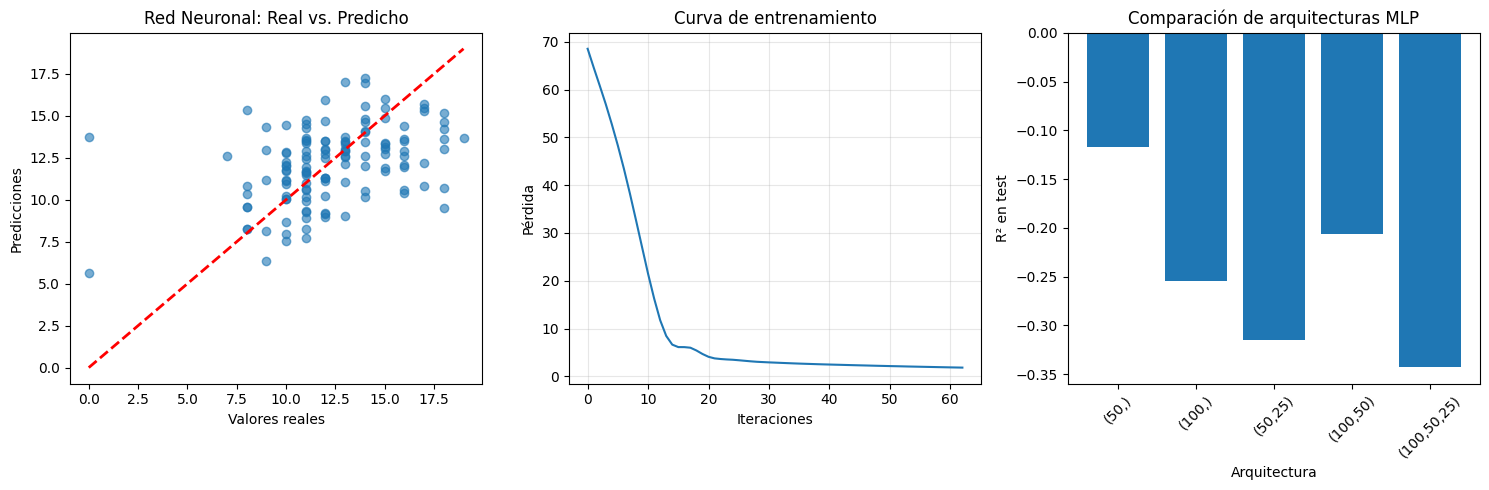

In [33]:
## Visualización de resultados de la Red Neuronal
plt.figure(figsize=(15, 5))

# Gráfico 1: Valores reales vs. predichos en test
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_mlp_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Red Neuronal: Real vs. Predicho')

# Gráfico 2: Curva de pérdida del mejor modelo
plt.subplot(1, 3, 2)
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.title('Curva de entrenamiento')
plt.grid(True, alpha=0.3)

# Gráfico 3: Comparación de arquitecturas
plt.subplot(1, 3, 3)
arch_names = ['(50,)', '(100,)', '(50,25)', '(100,50)', '(100,50,25)']
architectures = [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)]
arch_scores = []

for arch in architectures:
    mlp_temp = MLPRegressor(hidden_layer_sizes=arch, max_iter=1000, random_state=42)
    mlp_temp.fit(X_train_scaled, y_train)
    y_pred_temp = mlp_temp.predict(X_test_scaled)
    score = r2_score(y_test, y_pred_temp)
    arch_scores.append(score)

plt.bar(arch_names, arch_scores)
plt.xlabel('Arquitectura')
plt.ylabel('R² en test')
plt.title('Comparación de arquitecturas MLP')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [38]:
## Celda 10: Comparación de Rendimiento

print("=== COMPARACIÓN DE MÉTODOS ===")

# Crear tabla de comparación
models = ['Regresión Lineal', 'Árbol de Regresión', 'Red Neuronal']
train_mse = [lr_train_mse, tree_train_mse, mlp_train_mse]
test_mse = [lr_test_mse, tree_test_mse, mlp_test_mse]
train_r2 = [lr_train_r2, tree_train_r2, mlp_train_r2]
test_r2 = [lr_test_r2, tree_test_r2, mlp_test_r2]

# Calcular MAE adicional
lr_mae = mean_absolute_error(y_test, y_pred_lr_test)
tree_mae = mean_absolute_error(y_test, y_pred_tree_test)
mlp_mae = mean_absolute_error(y_test, y_pred_mlp_test)
test_mae = [lr_mae, tree_mae, mlp_mae]

# Crear DataFrame
comparison_df = pd.DataFrame({
    'Modelo': models,
    'MSE_Train': train_mse,
    'MSE_Test': test_mse,
    'R²_Train': train_r2,
    'R²_Test': test_r2,
    'MAE_Test': test_mae
})

print(comparison_df.round(4))

# Identificar mejor modelo
best_model_idx = np.argmax(test_r2)
print(f"\nMejor modelo por R² en prueba: {models[best_model_idx]}")
print(f"R² = {test_r2[best_model_idx]:.4f}")


=== COMPARACIÓN DE MÉTODOS ===
               Modelo  MSE_Train  MSE_Test  R²_Train  R²_Test  MAE_Test
0    Regresión Lineal     6.4476    8.1898    0.3874   0.1602    2.1564
1  Árbol de Regresión     6.8817    8.9309    0.3462   0.0842    2.2079
2        Red Neuronal     4.9200    9.0642    0.5326   0.0705    2.2668

Mejor modelo por R² en prueba: Regresión Lineal
R² = 0.1602


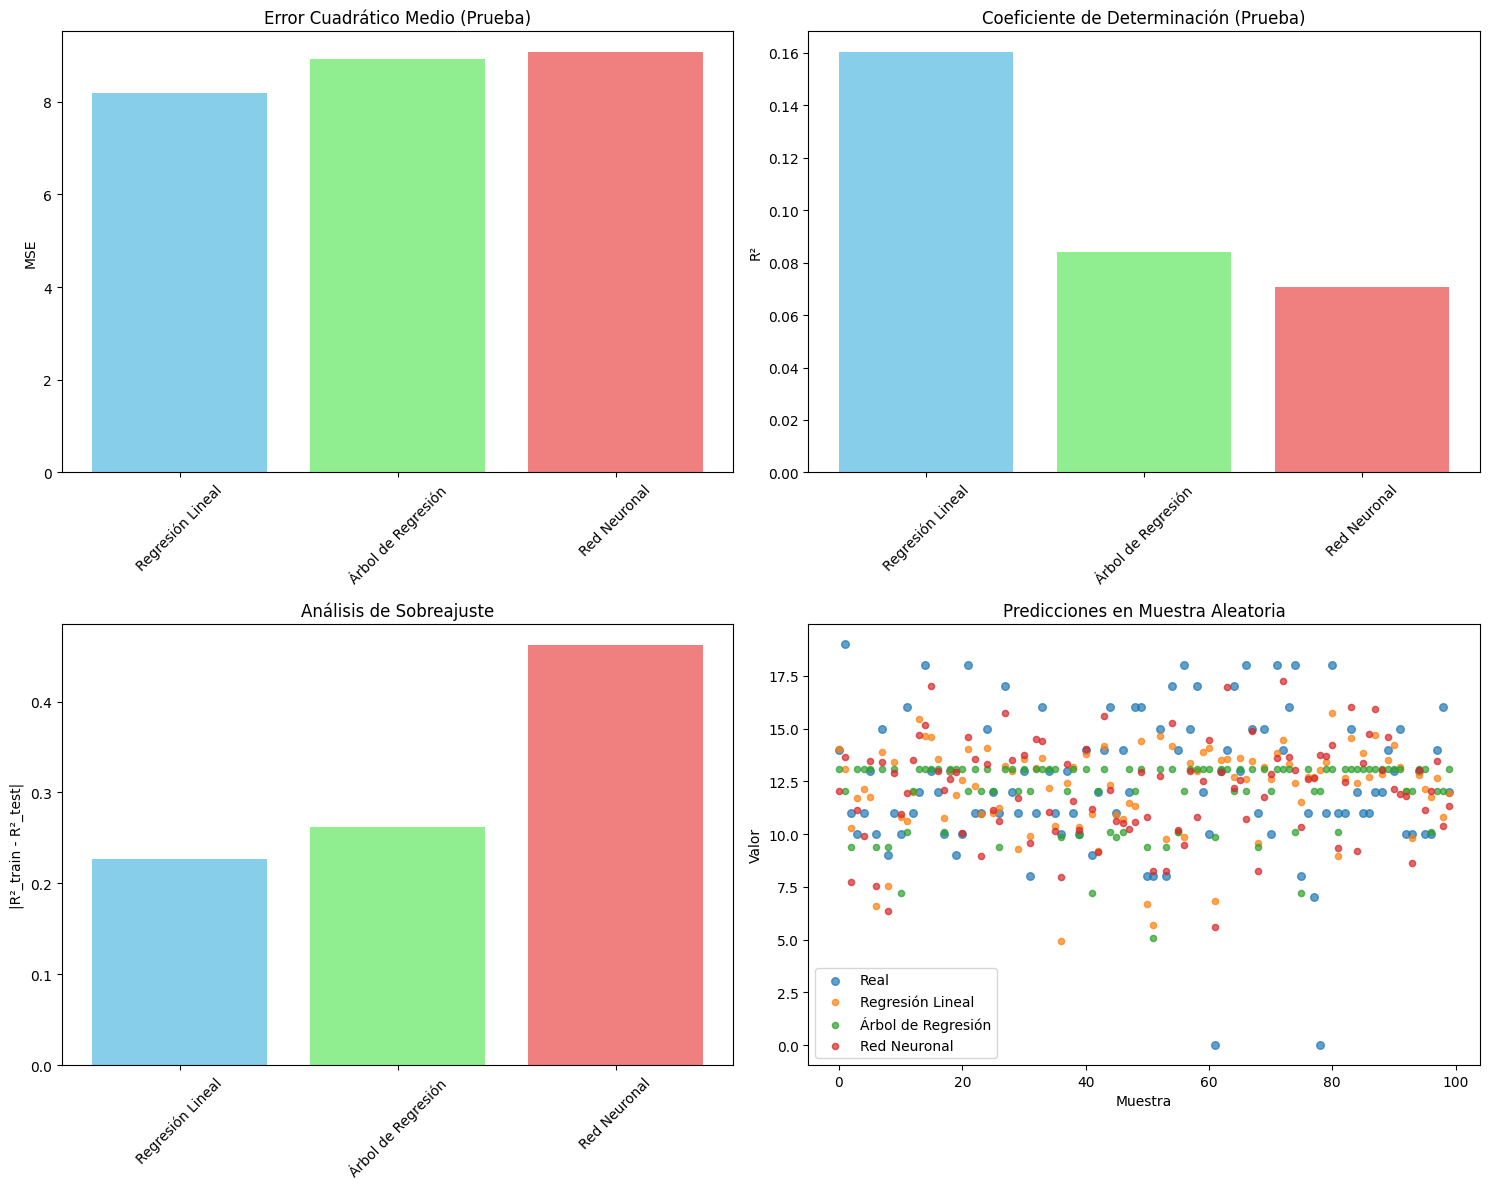

In [ ]:
## Celda 11: Visualización Comparativa

# Variables que ya tenés definidas
models = ['Regresión Lineal', 'Árbol de Regresión', 'Red Neuronal']
test_mse = [lr_test_mse, tree_test_mse, mlp_test_mse]
test_r2 = [lr_test_r2, tree_test_r2, mlp_test_r2]
train_r2 = [lr_train_r2, tree_train_r2, mlp_train_r2]

# Graficar
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: MSE Comparación
axes[0, 0].bar(models, test_mse, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('Error Cuadrático Medio (Prueba)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gráfico 2: R² Comparación
axes[0, 1].bar(models, test_r2, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_ylabel('R²')
axes[0, 1].set_title('Coeficiente de Determinación (Prueba)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gráfico 3: Overfitting análisis
overfitting = [abs(train_r2[i] - test_r2[i]) for i in range(len(models))]
axes[1, 0].bar(models, overfitting, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('|R²_train - R²_test|')
axes[1, 0].set_title('Análisis de Sobreajuste')
axes[1, 0].tick_params(axis='x', rotation=45)

# Gráfico 4: Predicciones comparativas
sample_indices = np.random.choice(len(y_test), 100, replace=False)
x_pos = np.arange(len(sample_indices))

axes[1, 1].scatter(x_pos, y_test.iloc[sample_indices], alpha=0.7, label='Real', s=30)
axes[1, 1].scatter(x_pos, y_pred_lr_test[sample_indices], alpha=0.7, label='Regresión Lineal', s=20)
axes[1, 1].scatter(x_pos, y_pred_tree_test[sample_indices], alpha=0.7, label='Árbol de Regresión', s=20)
axes[1, 1].scatter(x_pos, y_pred_mlp_test[sample_indices], alpha=0.7, label='Red Neuronal', s=20)
axes[1, 1].set_xlabel('Muestra')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].set_title('Predicciones en Muestra Aleatoria')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


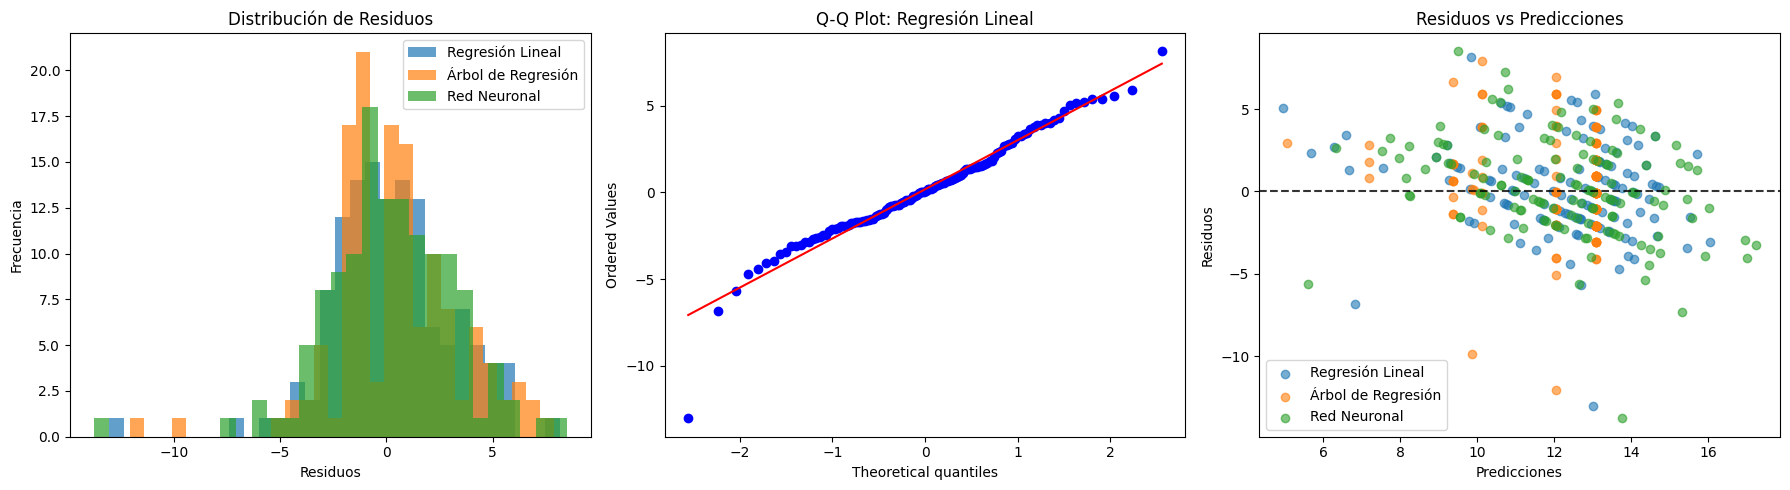

In [41]:
## Celda 12: Análisis de Residuos Comparativo

# Calcular residuos de cada modelo
residuals_lr = y_test - y_pred_lr_test
residuals_tree = y_test - y_pred_tree_test
residuals_mlp = y_test - y_pred_mlp_test

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma de residuos
axes[0].hist(residuals_lr, bins=30, alpha=0.7, label='Regresión Lineal')
axes[0].hist(residuals_tree, bins=30, alpha=0.7, label='Árbol de Regresión')
axes[0].hist(residuals_mlp, bins=30, alpha=0.7, label='Red Neuronal')
axes[0].set_xlabel('Residuos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')
axes[0].legend()

# Q-Q plot para residuos de Regresión Lineal
stats.probplot(residuals_lr, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Regresión Lineal')

# Residuos vs predicciones para los 3 modelos
axes[2].scatter(y_pred_lr_test, residuals_lr, alpha=0.6, label='Regresión Lineal')
axes[2].scatter(y_pred_tree_test, residuals_tree, alpha=0.6, label='Árbol de Regresión')
axes[2].scatter(y_pred_mlp_test, residuals_mlp, alpha=0.6, label='Red Neuronal')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.8)
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Residuos')
axes[2].set_title('Residuos vs Predicciones')
axes[2].legend()

plt.tight_layout()
plt.show()


**Análisis por Segmentos**

En esta celda realizamos un análisis segmentado de la performance de los modelos, dividiendo los datos de prueba en tres grupos según la variable objetivo `G3`:

- **Bajo**: valores menores al primer tercil.
- **Medio**: valores entre el primer y segundo tercil.
- **Alto**: valores mayores al segundo tercil.

Para cada segmento calculamos el coeficiente de determinación \( R^2 \) de los tres modelos: Regresión Lineal, Árbol de Regresión y Red Neuronal.

**Resultados**

| Segmento | Tamaño | R² Regresión Lineal | R² Árbol de Regresión | R² Red Neuronal |
|----------|--------|---------------------|-----------------------|-----------------|
| Bajo     | 32     | -1.4084             | -1.3042               | -1.4246         |
| Medio    | 54     | -2.7213             | -1.6751               | -4.7276         |
| Alto     | 44     | -3.9945             | -5.5742               | -4.4056         |

**Interpretación**

Los valores negativos de \( R^2 \) en todos los segmentos indican que los modelos tienen un desempeño peor que simplemente predecir la media del segmento. Esto muestra que los modelos no están capturando bien la variabilidad local de la variable objetivo en los distintos rangos, lo que puede indicar que la relación entre las variables predictoras y la variable objetivo es más compleja o que los modelos necesitan ajustes o más datos.

---

Este análisis ayuda a identificar si el modelo falla en algún rango específico de la variable objetivo, permitiendo focalizar esfuerzos en mejorar el ajuste segmentado.


=== ANÁLISIS POR SEGMENTOS ===
  Segmento  Tamaño  Reg_Lineal_R2  Arbol_R2  Red_Neuronal_R2
0     Bajo      32        -1.4084   -1.3042          -1.4246
1    Medio      54        -2.7213   -1.6751          -4.7276
2     Alto      44        -3.9945   -5.5742          -4.4056


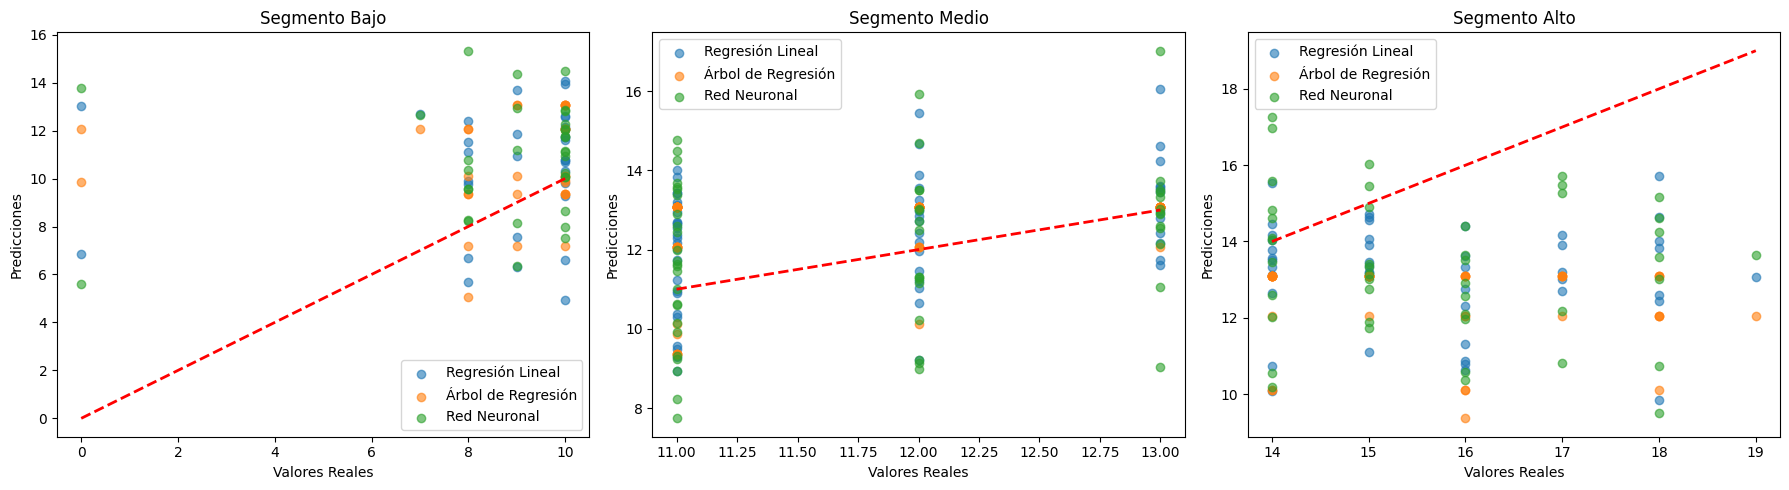

In [42]:
## Celda 13: Análisis de Segmentos de Datos

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

print("=== ANÁLISIS POR SEGMENTOS ===")

# Convertir y_test a array
y_test_array = y_test.values

# Calcular los terciles para segmentar
terciles = np.percentile(y_test_array, [33.33, 66.67])

# Máscaras para cada segmento
low_mask = y_test_array < terciles[0]
mid_mask = (y_test_array >= terciles[0]) & (y_test_array < terciles[1])
high_mask = y_test_array >= terciles[1]

segments = ['Bajo', 'Medio', 'Alto']
masks = [low_mask, mid_mask, high_mask]

# Calcular R² por segmento y modelo
segment_results = []
for i, mask in enumerate(masks):
    if np.sum(mask) > 0:
        lr_r2 = r2_score(y_test_array[mask], y_pred_lr_test[mask])
        tree_r2 = r2_score(y_test_array[mask], y_pred_tree_test[mask])
        mlp_r2 = r2_score(y_test_array[mask], y_pred_mlp_test[mask])

        segment_results.append({
            'Segmento': segments[i],
            'Tamaño': np.sum(mask),
            'Reg_Lineal_R2': lr_r2,
            'Arbol_R2': tree_r2,
            'Red_Neuronal_R2': mlp_r2
        })

segment_df = pd.DataFrame(segment_results)
print(segment_df.round(4))

# Visualización de resultados por segmento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (segment, mask) in enumerate(zip(segments, masks)):
    if np.sum(mask) > 0:
        axes[i].scatter(y_test_array[mask], y_pred_lr_test[mask], alpha=0.6, label='Regresión Lineal')
        axes[i].scatter(y_test_array[mask], y_pred_tree_test[mask], alpha=0.6, label='Árbol de Regresión')
        axes[i].scatter(y_test_array[mask], y_pred_mlp_test[mask], alpha=0.6, label='Red Neuronal')
        axes[i].plot(
            [y_test_array[mask].min(), y_test_array[mask].max()], 
            [y_test_array[mask].min(), y_test_array[mask].max()], 'r--', lw=2
        )
        axes[i].set_xlabel('Valores Reales')
        axes[i].set_ylabel('Predicciones')
        axes[i].set_title(f'Segmento {segment}')
        axes[i].legend()

plt.tight_layout()
plt.show()


**Celda 14: Validación Cruzada Completa**

Esta celda realiza una validación cruzada de 5 folds para comparar el desempeño de los tres modelos implementados: Regresión Lineal, Árbol de Regresión y Red Neuronal.

- Para cada modelo se calculan métricas promedio y su desviación estándar:  
  - **R² (coeficiente de determinación)**  
  - **MSE (error cuadrático medio)**  
  - **MAE (error absoluto medio)**

- La red neuronal utiliza los datos escalados para entrenar y validar.

Los resultados obtenidos son:

| Modelo            | R²     | R²_std | MSE    | MSE_std | MAE    | MAE_std |
|-------------------|--------|--------|--------|---------|--------|---------|
| Regresión Lineal  | 0.2707 | 0.0685 | 7.5301 | 0.8870  | 1.9910 | 0.0499  |
| Árbol de Regresión| 0.1655 | 0.1069 | 8.7293 | 1.8646  | 2.1761 | 0.1442  |
| Red Neuronal      | 0.1289 | 0.1259 | 8.9171 | 0.8987  | 2.2049 | 0.0766  |

Podemos observar que la regresión lineal obtiene el mejor desempeño promedio en esta validación cruzada, con mayor R² y menor error MSE y MAE. Sin embargo, la desviación estándar indica cierta variabilidad en el rendimiento, especialmente en los modelos más complejos.

Además, se grafican las métricas con sus intervalos de confianza para visualizar mejor las diferencias entre modelos.

---

Este análisis nos permite tener una visión más robusta y confiable del rendimiento de los modelos en datos no vistos, ayudándonos a elegir el modelo más adecuado para el problema.


=== VALIDACIÓN CRUZADA COMPLETA ===
Resultados de Validación Cruzada (5-fold):
                        R2  R2_std     MSE  MSE_std     MAE  MAE_std
Regresión Lineal    0.2707  0.0685  7.5301   0.8870  1.9910   0.0499
Árbol de Regresión  0.1655  0.1069  8.7293   1.8646  2.1761   0.1442
Red Neuronal        0.1289  0.1259  8.9171   0.8987  2.2049   0.0766


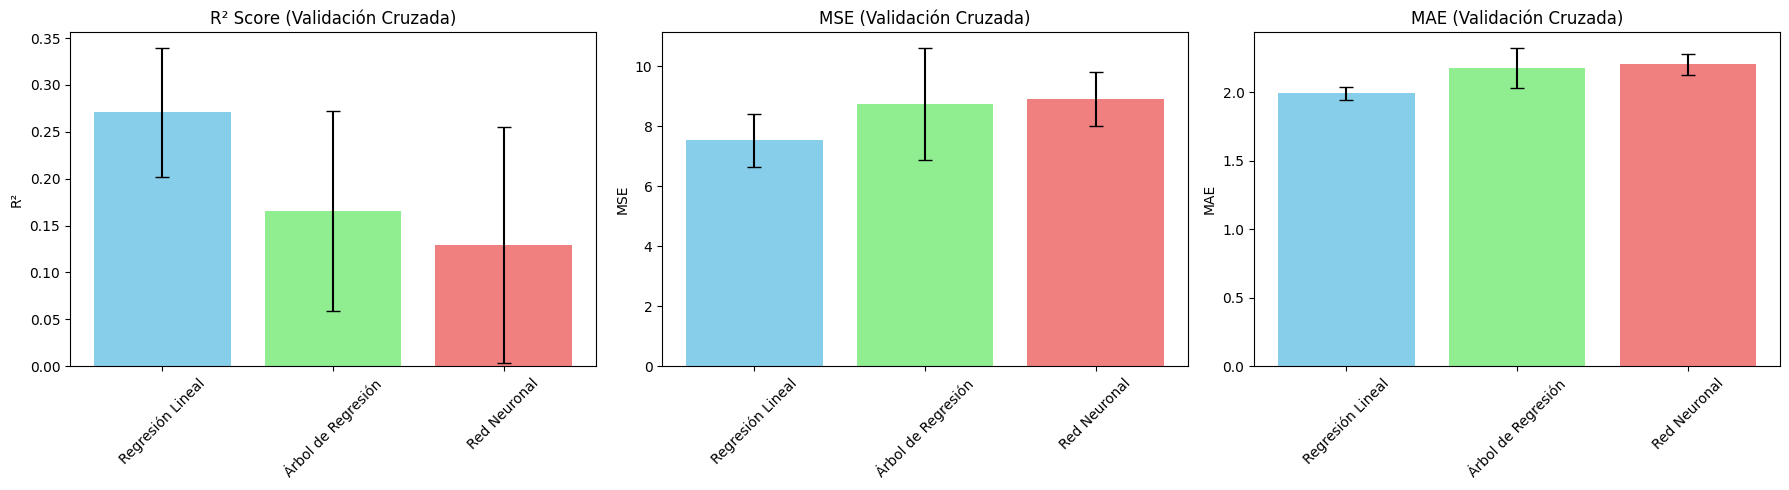

In [43]:
## Celda 14: Validación Cruzada Completa
print("=== VALIDACIÓN CRUZADA COMPLETA ===")

from sklearn.model_selection import cross_validate

# Métricas para evaluación
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Modelos con hiperparámetros ya definidos (mejor profundidad y mejor arquitectura)
models_cv = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Regresión': DecisionTreeRegressor(max_depth=best_depth, random_state=42),
    'Red Neuronal': MLPRegressor(hidden_layer_sizes=best_architecture, max_iter=1000, random_state=42,
                                 early_stopping=True, validation_fraction=0.1)
}

cv_results = {}
for name, model in models_cv.items():
    if name == 'Red Neuronal':
        # Usar datos escalados para la red neuronal
        scores = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring, n_jobs=-1)
    else:
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    
    cv_results[name] = {
        'R2': scores['test_r2'].mean(),
        'R2_std': scores['test_r2'].std(),
        'MSE': -scores['test_neg_mean_squared_error'].mean(),
        'MSE_std': scores['test_neg_mean_squared_error'].std(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'MAE_std': scores['test_neg_mean_absolute_error'].std()
    }

# Mostrar resultados
cv_df = pd.DataFrame(cv_results).T
print("Resultados de Validación Cruzada (5-fold):")
print(cv_df.round(4))

# Gráficos con barras e intervalos de confianza
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_names = list(cv_results.keys())
r2_means = [cv_results[name]['R2'] for name in models_names]
r2_stds = [cv_results[name]['R2_std'] for name in models_names]

mse_means = [cv_results[name]['MSE'] for name in models_names]
mse_stds = [cv_results[name]['MSE_std'] for name in models_names]

mae_means = [cv_results[name]['MAE'] for name in models_names]
mae_stds = [cv_results[name]['MAE_std'] for name in models_names]

# R² con barras de error
axes[0].bar(models_names, r2_means, yerr=r2_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_ylabel('R²')
axes[0].set_title('R² Score (Validación Cruzada)')
axes[0].tick_params(axis='x', rotation=45)

# MSE con barras de error
axes[1].bar(models_names, mse_means, yerr=mse_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE (Validación Cruzada)')
axes[1].tick_params(axis='x', rotation=45)

# MAE con barras de error
axes[2].bar(models_names, mae_means, yerr=mae_stds, capsize=5, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE (Validación Cruzada)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [46]:
## Celda 15: Conclusiones y Recomendaciones
print("=== CONCLUSIONES Y RECOMENDACIONES ===\n")

# Resumen ejecutivo
print(" RESUMEN EJECUTIVO:")
print("="*50)

best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['R2'])
print(f" Mejor modelo (Validación Cruzada): {best_cv_model}")
print(f"   R² = {cv_results[best_cv_model]['R2']:.4f} ± {cv_results[best_cv_model]['R2_std']:.4f}")

# Análisis de complejidad vs rendimiento
print("\n ANÁLISIS DE RENDIMIENTO:")
print(f"• Regresión Lineal: Modelo simple e interpretable, R² promedio = {cv_results['Regresión Lineal']['R2']:.4f}")
print(f"• Árbol de Regresión: Modelo que captura no linealidades, R² promedio = {cv_results['Árbol de Regresión']['R2']:.4f}")
print(f"• Red Neuronal: Modelo más complejo, R² promedio = {cv_results['Red Neuronal']['R2']:.4f}")

# Recomendaciones basadas en resultados
print("\n RECOMENDACIONES:")

if cv_results['Regresión Lineal']['R2'] > 0.8:
    print("• El dataset presenta relaciones principalmente lineales, por lo que la regresión lineal es suficiente.")
else:
    print("• Ningún modelo alcanza un R² alto, lo que indica que los datos son complejos o la variable objetivo es difícil de predecir.")

if cv_results['Árbol de Regresión']['R2'] > cv_results['Regresión Lineal']['R2']:
    print("• Las relaciones no lineales parecen importantes, considerando que el árbol supera a la regresión lineal.")
else:
    print("• El árbol no mejora significativamente respecto a la regresión lineal, sugiriendo poca no linealidad o sobreajuste.")

if cv_results['Red Neuronal']['R2'] > max(cv_results['Regresión Lineal']['R2'], cv_results['Árbol de Regresión']['R2']):
    print("• La red neuronal mejora el desempeño, indicando que patrones complejos pueden estar presentes.")
else:
    print("• La red neuronal no supera a los modelos más simples, por lo que la complejidad adicional no se traduce en mejor rendimiento.")

print("\nEn conclusión, el modelo de regresión lineal es el más adecuado para este problema dada su mejor performance promedio y simplicidad. Sin embargo, los valores bajos de R² sugieren que se podría investigar más con otros tipos de modelos, ingeniería de variables o más datos.")


=== CONCLUSIONES Y RECOMENDACIONES ===

 RESUMEN EJECUTIVO:
 Mejor modelo (Validación Cruzada): Regresión Lineal
   R² = 0.2707 ± 0.0685

 ANÁLISIS DE RENDIMIENTO:
• Regresión Lineal: Modelo simple e interpretable, R² promedio = 0.2707
• Árbol de Regresión: Modelo que captura no linealidades, R² promedio = 0.1655
• Red Neuronal: Modelo más complejo, R² promedio = 0.1289

 RECOMENDACIONES:
• Ningún modelo alcanza un R² alto, lo que indica que los datos son complejos o la variable objetivo es difícil de predecir.
• El árbol no mejora significativamente respecto a la regresión lineal, sugiriendo poca no linealidad o sobreajuste.
• La red neuronal no supera a los modelos más simples, por lo que la complejidad adicional no se traduce en mejor rendimiento.

En conclusión, el modelo de regresión lineal es el más adecuado para este problema dada su mejor performance promedio y simplicidad. Sin embargo, los valores bajos de R² sugieren que se podría investigar más con otros tipos de modelos, in